In [ ]:
# build semantic tree of imagenet 

create_semantic_info = False

if create_semantic_info:
    with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'wb') as pkl_file:
        semantic_info = ImagenetSemanticInfo()
        pickle.dump(semantic_info, pkl_file, pickle.HIGHEST_PROTOCOL)
else:
    with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'rb') as pkl_file:
        semantic_info = pickle.load(pkl_file)

In [ ]:
# find id-ood-counterparts 
# check all children of next parent, until there is a non-empty set with id_intersection 

semantic_tree = semantic_info.semantic_tree
tree_is_correct = semantic_tree.check_tree()
print(f'Tree is correct: {tree_is_correct}')

ood_intersection = set(classnames_dataset['Imagenet-X']['test']) & set(classnames_dataset['Imagenet-R']['test']) & set(classnames_dataset['Imagenet-C']['test']) & set(classnames_dataset['Imagenet-V2']['test'])
id_intersection = set(classnames_dataset['Imagenet-X']['val']) & set(classnames_dataset['Imagenet-R']['val']) & set(classnames_dataset['Imagenet-C']['val']) & set(classnames_dataset['Imagenet-V2']['val'])

node_n02760855 = semantic_tree.get_node_by_wnid('n02760855')
children_nodes = [child.wnid for child in node_n02760855.children]
print(f'Children of n02760855: {children_nodes}')

# ood_intersection = set(classnames_dataset['Imagenet-V2']['test'])
# id_intersection = set(classnames_dataset['Imagenet-V2']['val'])

# in_class = ood_intersection.pop()
# print(f'Start with: {in_class[0]}, {in_class[1]}')

# all_captured_children = []
# start_node = semantic_tree.get_node_by_wnid(in_class[1])
# next_parent = start_node.parent

# n = 1
# while set(all_captured_children) & id_intersection == set(): 
#     next_children = next_parent.children 
#     while not len(next_children) == 0: 
        
        
    
#         next_children = [next_child.children for next_child in next_children]
#     n = n + 1

# print(f'Stopped after {n} rows')


print(f'OOD-IntersectionX = {len(ood_intersection)}, ID-Intersection = {len(id_intersection)}')

#print id-wnid and ood-wnids to a file
# with open('/home/afroehli/coding/tmp_data/imagenet_v2_ood_wnids.txt', 'w') as ood_wnids: 
#     for ood_elem in ood_intersection:
#         n_written = ood_wnids.write(ood_elem[1] + '\n')
#         print(f'Number of written byes = {n_written}')

# with open(r'/home/afroehli/coding/tmp_data/imagenet_v2_id_wnids.txt', 'w') as id_wnids: 
#     for id_name, id_wnid in id_intersection:
#         id_wnids.write(id_wnid + '\n') 

id_neighbours = dict()
all_id_wnids = [class_with_wnid[1] for class_with_wnid in id_intersection]

threshold = 6
not_found = 0

parents_in_id = []

# for each class in ood, find all neighbours 
# iteration over class/wnid-level in ood_intersection | Sidewards
for class_name, class_wnid in ood_intersection:
    
    # catch all nodes within subtree 
    visited_nodes = set()

    # trace documents path from ood-instance to id-instances in imagenet-tree 
    trace = []

    # actually ood_node
    ood_node = semantic_tree.get_node_by_wnid(class_wnid)
    visited_nodes.add(ood_node)

    parents = []
    caught_children = []
    
    parents.append(ood_node.parent)

    # iteration over hierarchy in tree | Upwards
    for n in range(0, threshold):
        starting_parent = parents[len(parents) - 1]

        # check if parent is a id-instance 
        if starting_parent.wnid in all_id_wnids: 
             parents_in_id.append(starting_parent)

        # iteration over all children of current parent node, ood_node not covered | Downwards
        
        while len(parents) > 0:
            parent_node = parents.pop() 
            visited_nodes.add(parent_node)

            children_from_tree = parent_node.children
            new_children = [child for child in children_from_tree if not child == ood_node]

            children_wnids = [child.wnid for child in new_children]
            # all found neighbours of ood-node also in id-class will be concatenated
            id_wnid_neighbours = [id_wnid for id_wnid in all_id_wnids if id_wnid in children_wnids]
            try:
                id_neighbours[class_wnid]['id_wnids'].extend(id_wnid_neighbours)
                id_neighbours[class_wnid]['level'] = n
            except KeyError:
                id_neighbours[class_wnid] = {'id_wnids': id_wnid_neighbours, 'trace': '', 'level': n}
            
            # repeat child discovery until the bottom of the tree
            for child in new_children:
                if len(child.children) > 0:
                      parents.append(child)
                elif child.wnid in id_neighbours[class_wnid]['id_wnids']:
                    visited_nodes.add(child)

        if len(id_neighbours[class_wnid]['id_wnids']) > 0: 
            ood_id_subtree = ImagenetSemanticSubtree(semantic_tree, ood_wnid=class_wnid, 
                                                        id_wnids=id_neighbours[class_wnid]['id_wnids'], map_to_word=semantic_info.wnid_to_word)
            ood_id_subtree.create_subtree(starting_parent)
            # create list of init_nodes, build paths within subtree
            on_path_init_nodes = [semantic_tree.get_node_by_wnid(id_wnid) for id_wnid in id_neighbours[class_wnid]['id_wnids']]
            on_path_init_nodes.append(semantic_tree.get_node_by_wnid(class_wnid))
            for init_node in on_path_init_nodes: 
                if init_node == None:
                    print(' #### InitNode as None detected ###')

            # mark paths within subtree
            entity_reached = ood_id_subtree.propagate_paths(on_path_init_nodes, visited_nodes)
    
            # get string representation of subtree
            if not entity_reached:
                ood_id_trace = ood_id_subtree.parse_tree()
            else:
                ood_id_trace = 'contains entity: ' + ood_id_subtree.parse_tree()
                
            id_neighbours[class_wnid]['trace'] = ood_id_trace

            # clear paths within subtree
            ood_id_subtree.clear_paths(visited_nodes)

            break
    
        # move one hierarchy up in tree
        ood_node = starting_parent
        parents.append(ood_node.parent) 

for ood_key in id_neighbours.keys():
    print(f'\033[1m{ood_key}\033[0m next to: \033[1m{id_neighbours[ood_key]['id_wnids']}\033[0m')
    # print(f'\033[1m{semantic_info.wnid_to_classname[ood_key]}\033[0m next to: \033[1m{[semantic_info.wnid_to_classname[id_wnid] for id_wnid in id_neighbours[ood_key]['id_wnids']]}\033[0m')
    print(f'Trace: {id_neighbours[ood_key]['trace']}')
    print(f'Level: {id_neighbours[ood_key]['level']}')
    
non_empty = 0
for ood_wnid in id_neighbours.keys(): 
    if len(id_neighbours[ood_wnid]['id_wnids']) !=  0:
        non_empty = non_empty + 1 

print(f'Non-empty lists: {non_empty}')

print(f'Parents in ID: {len(parents_in_id)}')
print(parents_in_id)

Correct classified is-a relations: 75850
Tree is correct: True
Children of n02760855: ['n02749479', 'n02907391']
OOD-IntersectionX = 63, ID-Intersection = 72
n02096585 next to: ['n02094433']
Trace: ( terrier ( Australian terrier (...)  fox terrier ( smooth-haired fox terrier (...)  wire-haired fox terrier (...) ) soft-coated wheaten terrier (...)  wirehair ( Welsh terrier ( Sealyham terrier (...) ) Lakeland terrier (...) ) Dandie Dinmont (...)  Airedale (...)  Lhasa (...)  Yorkshire terrier () West Highland white terrier (...)  schnauzer ( giant schnauzer (...)  miniature schnauzer (...)  standard schnauzer (...) ) bullterrier ( Staffordshire bullterrier (...)  American Staffordshire terrier (...) ) Norfolk terrier (...)  cairn (...)  Kerry blue terrier (...)  Scotch terrier (...)  Boston bull () Bedlington terrier (...)  Irish terrier (...)  silky terrier (...)  Skye terrier ( Clydesdale terrier (...) ) Norwich terrier (...)  Tibetan terrier (...)  rat terrier ( Manchester terrier ( t

In [ ]:
# store identified union set of id- and ood-classes 

common_classes = id_intersection | ood_intersection

with open('/home/afroehli/coding/dinov2_ood/storage/union_set_classes.txt', 'w') as file:
    for cname, wnid in common_classes:
        file.write(wnid + '\n')

# extract information from generated semantic-subtrees 

with open(r'/home/afroehli/coding/dinov2_ood/ood_id_balanced_split.txt', 'w') as balanced_split:
    with open(r'/home/afroehli/coding/dinov2_ood/ood_id_unbalacned_split.txt', 'w') as unbalanced_split:

        for class_name, class_wnid in ood_intersection:
    
            id_wnids = list(id_neighbours[class_wnid]['id_wnids'])
            if len(id_wnids) <= 1:
                balanced_split.write(f'OOD = {class_wnid} | {semantic_info.wnid_to_classname[class_wnid]},\t\t' 
                                     f'ID = {id_wnids[0]} | {semantic_info.wnid_to_classname[id_wnids[0]]}')
                balanced_split.write('\n')
            else:
                id_info_unbalanced = [(id_wnid, semantic_info.wnid_to_classname[id_wnid]) for id_wnid in id_wnids]
                unbalanced_split.write(f'OOD = {class_wnid} | {semantic_info.wnid_to_classname[class_wnid]},\t\t' 
                                        f'ID = {id_info_unbalanced}')
                unbalanced_split.write('\n')



In [ ]:
# create table for ood-id-mapping information 

with open('/home/afroehli/coding/dinov2_ood/ood_id_balanced_split.csv', 'w', newline='') as balanced_table: 
    with open('/home/afroehli/coding/dinov2_ood/ood_id_unbalanced_split.csv', 'w', newline='') as unbalanced_table:

        balanced_writer = csv.writer(balanced_table, delimiter=';')
        unbalanced_writer = csv.writer(unbalanced_table, delimiter=';')

        balanced_writer.writerow(['OOD Name', 'ID Name'])
        unbalanced_writer.writerow(['OOD Name', 'ID Name'])

        for _, class_wnid in ood_intersection:
            ood_class = semantic_info.wnid_to_classname[class_wnid]
            id_wnids = id_neighbours[class_wnid]['id_wnids']

            if len(id_wnids) <= 1:
                id_class = semantic_info.wnid_to_classname[id_wnids[0]]
                balanced_writer.writerow([ood_class, class_wnid, id_class, id_wnids[0]])
            else:
                id_classes = [semantic_info.wnid_to_classname[id_wnid] for id_wnid in id_wnids]
                id_classes = zip(id_classes, id_wnids)
                next_row = [ood_class, class_wnid]
                next_row.extend(id_classes)
                unbalanced_writer.writerow(next_row)


In [ ]:
# load information from semantic splits 

class_splits = []
with open('/home/afroehli/coding/dinov2_ood/ood_id_self_selected_labels.csv', newline='') as split_file:
    split_reader = csv.reader(split_file, delimiter=';')
    for line in split_reader: 
        class_splits.append((line[1], line[3]))
        ood_class = semantic_info.wnid_to_classname[line[1]]
        id_class = semantic_info.wnid_to_classname[line[3]]
        print(f'Split should be: {line[0]}, {line[2]}; is actual: {ood_class}, {id_class}')

Split should be: vulture,  bald eagle; is actual:  vulture,  bald eagle
Split should be: Rottweiler,  Boxer; is actual:  Rottweiler,  Boxer
Split should be: Boston Terrier,  Yorkshire Terrier; is actual:  Boston Terrier,  Yorkshire Terrier
Split should be: Chow Chow,  Pomeranian; is actual:  Chow Chow,  Pomeranian
Split should be: Whippet,  Italian Greyhound; is actual:  Whippet,  Italian Greyhound
Split should be: Shih Tzu,  Chihuahua; is actual:  Shih Tzu,  Chihuahua
Split should be: king penguin,  pelican; is actual:  king penguin,  pelican
Split should be: gorilla,  orangutan; is actual:  gorilla,  orangutan
Split should be: junco,  goldfinch; is actual:  junco,  goldfinch
Split should be: assault rifle,  cannon; is actual:  assault rifle,  cannon
Split should be: French Bulldog,  Boxer; is actual:  French Bulldog,  Boxer
Split should be: chimpanzee,  orangutan; is actual:  chimpanzee,  orangutan
Split should be: chameleon,  green iguana; is actual:  chameleon,  green iguana
Split 

In [ ]:
# Load DINOv2 model 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()
dinov2_vits14.to(device)

transform = transforms.Compose([transforms.Resize((154, 210)),
                                transforms.ToTensor()])


Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [ ]:
# help functions for measuring semantic encoding distance 

def get_random_class() -> str:
    all_classes = list(imagenet_x_sorted.keys())
    n_classes = len(all_classes)
    next_int = random.randint(0, n_classes - 1)
    next_class = all_classes[next_int]

    return next_class

In [ ]:
with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'rb') as pickle_file:
    imagenet_x_val_results = pickle.load(pickle_file)

In [ ]:

# speed up computation 
preloaded_results = True
if not preloaded_results:
    imagenet_x_val_results = dict()

ood_id_random_combination = []
random_compare_set = dict()
random_set_size = 10 

random.seed(3)

for it, ood_id_pair in enumerate(class_splits): 

    ood_wnid, id_wnid = ood_id_pair 
    random_class_wnid = get_random_class()
    random_set = [get_random_class() for i in range(0, random_set_size)]

    ood_id_random_combination.append((ood_wnid, id_wnid, random_class_wnid))
    random_compare_set[(ood_wnid, id_wnid, random_class_wnid)] = copy.deepcopy(random_set)

    print(f'Iteration {it}. Next triple processed: {semantic_info.wnid_to_classname[ood_wnid]}',
          f', {semantic_info.wnid_to_classname[id_wnid]}, {semantic_info.wnid_to_classname[random_class_wnid]}.\n'
          f'Random-compare-set: {[semantic_info.wnid_to_classname[random_wnid] for random_wnid in random_set]}.')
    
    
    image_processed = 0
    
    wnid_set = [ood_wnid, id_wnid, random_class_wnid]
    wnid_set.extend(random_set)
    for wnid in wnid_set:

        covered_classes = list(imagenet_x_val_results.keys())
        
        if not wnid in covered_classes:
            for dassl_instance in imagenet_x_sorted[wnid]:

                pic_data = transform(Image.open(dassl_instance.impath).convert('RGB')).unsqueeze(0)
                pic_data_cuda = pic_data.to(device)

                model_out = dinov2_vits14(pic_data_cuda)
                try: 
                    imagenet_x_val_results[wnid].append(model_out.cpu().data.numpy()[0])
                except KeyError:
                    imagenet_x_val_results[wnid] = [model_out.cpu().data.numpy()[0]]

            image_processed = image_processed + len(imagenet_x_sorted[wnid])
        else:
            print(f'Class *{semantic_info.wnid_to_classname[wnid]}* is already covered.')

    print(f'Images processed in this iteration: {image_processed}')


Iteration 0. Next triple processed:  vulture ,  bald eagle,  poke bonnet.
Random-compare-set: [' Gordon Setter', ' sea slug', ' Toy Poodle', ' moped', ' volleyball', ' Appenzeller Sennenhund', ' mountain', ' Persian cat', ' Boston Terrier', ' little blue heron'].
Images processed in this iteration: 650
Iteration 1. Next triple processed:  Rottweiler ,  Boxer,  French Bulldog.
Random-compare-set: [' smooth newt', ' vacuum cleaner', ' schooner', ' chocolate syrup', ' cardboard box / carton', ' bittern bird', ' bikini', ' rock beauty fish', ' drilling rig', ' meatloaf'].
Images processed in this iteration: 650
Iteration 2. Next triple processed:  Boston Terrier ,  Yorkshire Terrier,  jellyfish.
Random-compare-set: [' weighing scale', ' hermit crab', ' coral reef', ' farm plow', ' ant', ' sports car', ' fly', ' baby bib', ' longhorn beetle', ' bee'].
Class * Boston Terrier* is already covered.
Images processed in this iteration: 600
Iteration 3. Next triple processed:  Chow Chow ,  Pomeran

In [ ]:
# dump calculated embedding values of selected class 

with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_x_val_results, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/ood_id_random_combination.pkl', 'wb') as pickle_file:
    pickle.dump(ood_id_random_combination, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/random_compare_set.pkl', 'wb') as pickle_file:
    pickle.dump(random_compare_set, pickle_file, pickle.HIGHEST_PROTOCOL)


In [ ]:
# check if dump was successful 

with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'rb') as pickle_file:
    imagenet_x_val_results = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/ood_id_random_combination.pkl', 'rb') as pickle_file:
    ood_id_random_combination = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/random_compare_set.pkl', 'rb') as pickle_file:
    random_compare_set = pickle.load(pickle_file)


In [ ]:
# calculate means of embeddings 

statistics_dict = dict()

# def class_std_area(class_1, class_2):
#     return vect_dim_std_area(class_1, class_2)

def dim_std_area(std_1, std_2):
    if std_1 < std_2:
        return 2 * std_2 
    else:
        return 2 * std_1 

vect_dim_std_area = np.vectorize(dim_std_area)
# vect_class_std_area = np.vectorize(class_std_area)

# def max_min_on_class(class_mean, class_std):
#     return vect_max_min_on_dim(class_mean, class_std)

def max_min_on_dim(dim_mean, dim_std):
    return (dim_mean - dim_std, dim_mean + dim_std)

vect_max_min_on_dim = np.vectorize(max_min_on_dim)
# vect_max_min_on_class = np.vectorize(max_min_on_class)

# def calc_union_area(max_min_class_1, max_min_class_2):
#      return vect_calc_union_area_dim(max_min_class_1, max_min_class_2)
    
def calc_union_area_dim(min_dim_class_1, max_dim_class_1, min_dim_class_2, max_dim_class_2):
    min_1 = min_dim_class_1 
    max_1 = max_dim_class_1 

    min_2 = min_dim_class_2
    max_2 = max_dim_class_2
    
    # no intersection 
    if max_1 <= min_2 or max_2 <= min_1:
        return 0 
    # left overlapping of 1 / right overlapping of 2
    elif min_1 <= min_2 and max_1 <= max_2:
        return max_1 - min_2
    # left overlapping of 2 / right overlapping of 1
    elif min_2 <= min_1 and max_2 <= max_1:
        return max_2 - min_1 
    # 1 within 2 
    elif max_1 <= max_2:
        return max_1 - min_1 
    # 2 within 1
    else:
        return max_2 - min_2
    
vect_calc_union_area_dim = np.vectorize(calc_union_area_dim)
# vect_calc_union_area = np.vectorize(calc_union_area)


for class_combination in ood_id_random_combination: 

    ood_wnid, id_wnid, random_wnid = class_combination 

    ood_results = np.array(imagenet_x_val_results[ood_wnid])
    id_results = np.array(imagenet_x_val_results[id_wnid])
    random_results = np.array(imagenet_x_val_results[random_wnid])
    # shape = 10 x 50 x 384  (N pictures)
    random_compare_results = np.array([imagenet_x_val_results[comp_wnid] for comp_wnid in random_compare_set[class_combination]])

    ood_mean = np.mean(ood_results, axis=0)
    id_mean = np.mean(id_results, axis=0)
    random_mean = np.mean(random_results, axis=0)

    # shape = 10 x 384
    random_compare_mean_1 = np.mean(random_compare_results, axis=1)
    # shape = 384
    random_compare_mean = np.mean(random_compare_mean_1, axis=0)
    
    ood_std = np.std(ood_results, axis=0)
    id_std = np.std(id_results, axis=0)
    random_std = np.std(random_results, axis=0)
    
    diff_id_ood = np.abs(id_mean - ood_mean)
    diff_random_ood = np.abs(random_mean - ood_mean)
    diff_random_comp_ood = np.abs(random_compare_mean - ood_mean)

    statistics_dict[class_combination] = dict()
    
    true_false_list = (diff_id_ood < diff_random_ood).tolist()
    id_is_nearer = true_false_list.count(True)
    statistics_dict[class_combination]['id_random'] = id_is_nearer

    true_false_list = (diff_id_ood < ood_std).tolist()
    id_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['id_std'] = id_within_std

    true_false_list = (diff_random_ood < ood_std).tolist()
    random_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['random_std'] = random_within_std

    true_false_list = (diff_id_ood < diff_random_comp_ood).tolist()
    id_is_nearer_comp = true_false_list.count(True)
    statistics_dict[class_combination]['id_random_comp'] = id_is_nearer_comp 

    true_false_list = (diff_random_comp_ood < ood_std).tolist()
    random_comp_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['random_comp_std'] = random_comp_within_std

    # calculate coverage between stds of ood and id per dim 
    
    # shape (384)
    ood_id_std_area = vect_dim_std_area(ood_std, id_std)
    ood_random_std_area = vect_dim_std_area(ood_std, random_std)

    # for id, ood, random: for each class: for each dim: (min = mean - std, max = mean + std)
    max_min_per_dim_id = vect_max_min_on_dim(id_mean, id_std) 
    max_min_per_dim_ood = vect_max_min_on_dim(ood_mean, ood_std)
    max_min_per_dim_random = vect_max_min_on_dim(random_mean, random_std)

    union_area_between_ood_id = vect_calc_union_area_dim(max_min_per_dim_id[0], max_min_per_dim_id[1], 
                                                         max_min_per_dim_ood[0], max_min_per_dim_ood[1])
    union_area_between_ood_random = vect_calc_union_area_dim(max_min_per_dim_random[0], max_min_per_dim_random[1], 
                                                             max_min_per_dim_ood[0], max_min_per_dim_ood[1])
    covered_area_ood_id = union_area_between_ood_id / ood_id_std_area
    covered_area_ood_random = union_area_between_ood_random / ood_random_std_area

    statistics_dict[class_combination]['id_std_covered'] = covered_area_ood_id 
    statistics_dict[class_combination]['random_std_covered'] = covered_area_ood_random


In [ ]:
# store statistics on ood-id-random combinations

with open('/home/afroehli/coding/pickle_data/ood_id_random_statistics.pkl', 'wb') as pickle_file:
    pickle.dump(statistics_dict, pickle_file, pickle.HIGHEST_PROTOCOL)


In [ ]:
# load dumped statistics information on ood-id-random combination

with open('/home/afroehli/coding/pickle_data/ood_id_random_statistics.pkl', 'rb') as pickle_file:
    statistics_ood_id_random = pickle.load(pickle_file)

                                          Comb  Rel        Cov
0      ('n01616318', 'n01614925', 'n02869837')   ID  86.419083
1      ('n01616318', 'n01614925', 'n02869837')   ID  52.364666
2      ('n01616318', 'n01614925', 'n02869837')   ID  59.112949
3      ('n01616318', 'n01614925', 'n02869837')   ID  49.337219
4      ('n01616318', 'n01614925', 'n02869837')   ID  83.553246
...                                        ...  ...        ...
46075  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46076  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46077  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46078  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46079  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000

[46080 rows x 3 columns]
    DiffIDRandomFromOOD  50%
0             62.500000   50
1             53.645833   50
2             54.687500   50
3             65.364583   50
4             69.791667   50
5             58.333333   50
6             5

/tmp/ipykernel_403358/166053674.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  std_coverage_df = pd.concat([std_coverage_df, new_rows_df], ignore_index=True)


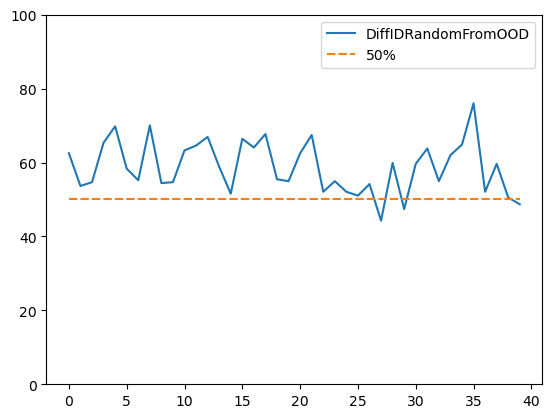

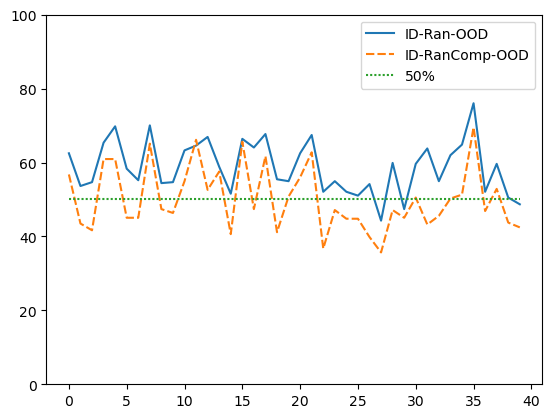

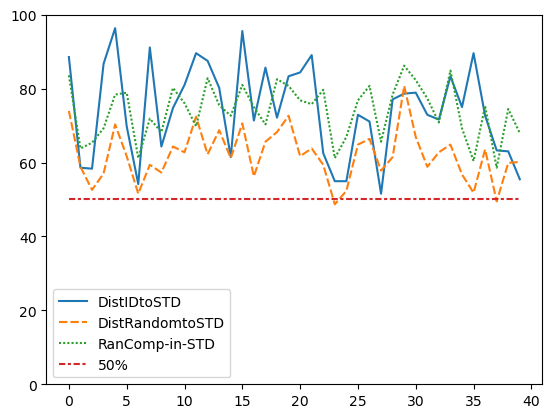

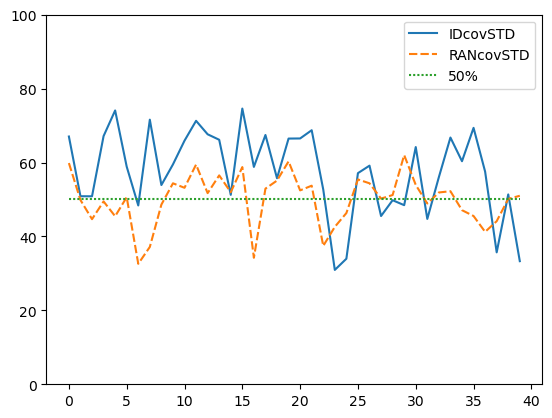

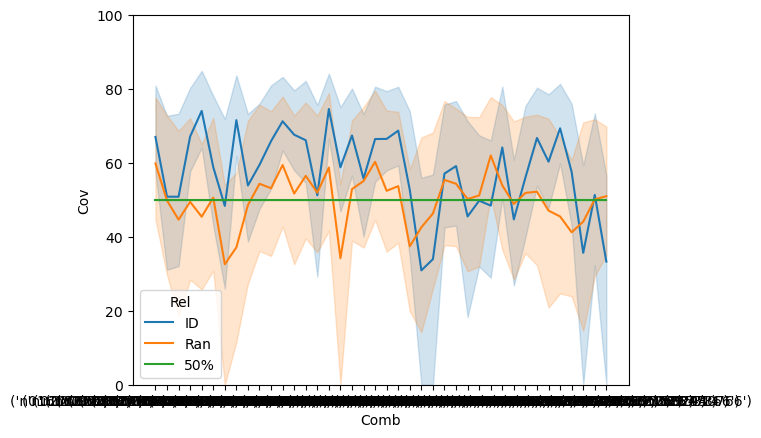

In [ ]:
# visualize statistics on ood-id-random in single graph 

all_combinations = list(statistics_ood_id_random.keys())

all_id_random_rel = [(statistics_ood_id_random[combination]['id_random'] / 384) * 100 for combination in all_combinations]
all_id_random_comp_rel = [(statistics_ood_id_random[combination]['id_random_comp'] / 384) * 100 for combination in  all_combinations]
all_id_std_rel = [(statistics_ood_id_random[combination]['id_std'] / 384) * 100 for combination in  all_combinations]
all_random_std_rel = [(statistics_ood_id_random[combination]['random_std'] / 384) * 100 for combination in  all_combinations]
all_random_comp_std_rel = [(statistics_ood_id_random[combination]['random_comp_std'] / 384) * 100 for combination in  all_combinations]

std_coverage_df = pd.DataFrame(columns=['Comb', 'Rel', 'Cov'])

fifty_line = [50 for i in range(0, 384)]
fifty_line_df = pd.DataFrame(data=fifty_line, columns=["Cov"])
fifty_line_df['Rel'] = '50%'

for combination in list(statistics_ood_id_random.keys()):
    new_rows_id_df = pd.DataFrame(data=(statistics_ood_id_random[combination]['id_std_covered'] * 100), columns=["Cov"])
    new_rows_id_df['Rel'] = 'ID'
    new_rows_random_df = pd.DataFrame(data=(statistics_ood_id_random[combination]['random_std_covered'] * 100), columns=["Cov"])
    new_rows_random_df['Rel'] = 'Ran'
    
    new_rows_df = pd.concat([new_rows_id_df, new_rows_random_df, fifty_line_df], axis=0)
    new_rows_df['Comb'] = str(combination)
    
    std_coverage_df = pd.concat([std_coverage_df, new_rows_df], ignore_index=True)
    # std_coverage_df = pd.concat(std_coverage_df, new_rows_random_df, ignore_indexes=True)

std_coverage_id_ood = [np.mean(statistics_ood_id_random[combination]['id_std_covered']) * 100 for combination in all_combinations]
std_coverage_random_ood = [np.mean(statistics_ood_id_random[combination]['random_std_covered']) * 100 for combination in all_combinations]
line_at_fifty = [50 for i in range(0, len(all_combinations))]

all_id_random_df = pd.DataFrame(data=list(zip(all_id_random_rel, line_at_fifty)), 
                                columns=['DiffIDRandomFromOOD', '50%'])

distance_to_std_df = pd.DataFrame(data=list(zip(all_id_std_rel, all_random_std_rel, all_random_comp_std_rel, line_at_fifty)),
                                columns=['DistIDtoSTD', 'DistRandomtoSTD', 'RanComp-in-STD', '50%'])

covered_std_of_ood_df = pd.DataFrame(data=list(zip(std_coverage_id_ood, std_coverage_random_ood, line_at_fifty)),
                                  columns=['IDcovSTD', 'RANcovSTD', '50%'])

id_random_comp_df = pd.DataFrame(data=list(zip(all_id_random_rel, all_id_random_comp_rel, line_at_fifty)),
                                 columns=['ID-Ran-OOD', 'ID-RanComp-OOD', '50%'])


plt.ylim((0,100))
sns.lineplot(data=all_id_random_df)
plt.show()

plt.ylim((0,100))
sns.lineplot(data=id_random_comp_df)
plt.show()

plt.ylim((0,100))
sns.lineplot(data=distance_to_std_df)
plt.show()

plt.ylim((0, 100))
sns.lineplot(data=covered_std_of_ood_df)
plt.show()

plt.ylim((0, 100))
sns.lineplot(data=std_coverage_df, x='Comb', y='Cov', hue='Rel', markers=True, errorbar=('pi', 50))
plt.show()